📉 MAE: 0.1333
📉 RMSE: 0.2298
📈 R² Score: 0.99542


/tmp/ipykernel_37/1302857308.py:76: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


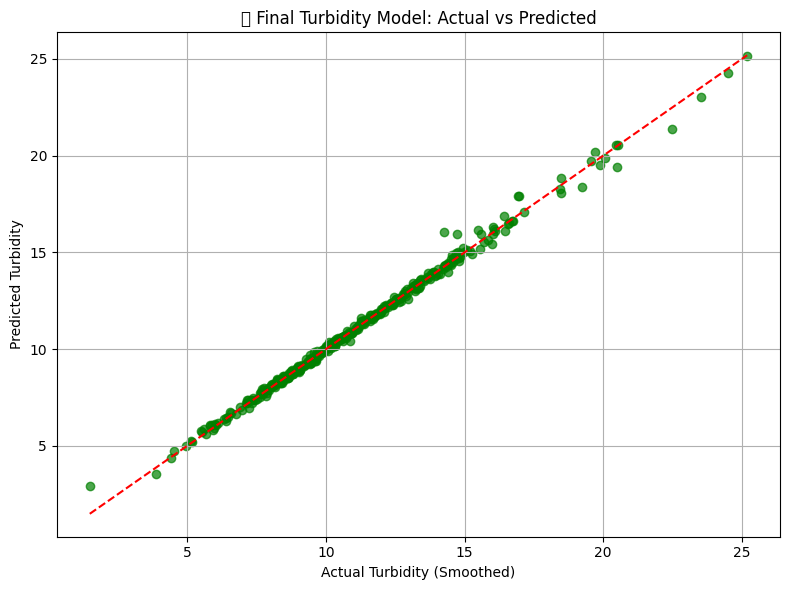

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/kaggle/input/anomaly/anomaly_detection (1).csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

# Smooth target
df["turbidity_smooth"] = df["turbidity"].rolling(window=3).mean()

# Feature engineering
df["turbidity_diff"] = df["turbidity"].diff()
df["turbidity_rollmean_3"] = df["turbidity"].rolling(window=3).mean()
df["turbidity_rollstd_3"] = df["turbidity"].rolling(window=3).std()
df["tds_x_temp"] = df["TDS"] * df["temperature"]
df["tds_over_temp"] = df["TDS"] / (df["temperature"] + 1)
df["turb_x_ph"] = df["turbidity"] * df["pH"]
df["tds_temp_ratio"] = df["TDS"] / (df["temperature"] + 1)
df["turbidity_x_ph"] = df["turbidity"] * df["pH"]
df["temp_sqr"] = df["temperature"]**2
df["tds_diff"] = df["TDS"].diff()
df["temp_diff"] = df["temperature"].diff()

df = df.dropna().reset_index(drop=True)

# Feature set
features_turbidity = [
    "TDS", "temperature", "pH",
    "tds_temp_ratio", "turbidity_x_ph", "temp_sqr",
    "tds_diff", "temp_diff", "turbidity_diff",
    "turbidity_rollmean_3", "turbidity_rollstd_3",
    "tds_x_temp", "tds_over_temp", "turb_x_ph"
]

X = df[features_turbidity]
y = df["turbidity_smooth"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 MAE: {mae:.4f}")
print(f"📉 RMSE: {rmse:.4f}")
print(f"📈 R² Score: {r2:.5f}")

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Turbidity (Smoothed)")
plt.ylabel("Predicted Turbidity")
plt.title("🌊 Final Turbidity Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# 💾 Save model
import joblib
joblib.dump(model, "turbidity_forecast_model.pkl")

['turbidity_forecast_model.pkl']

/tmp/ipykernel_36/4167871951.py:18: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


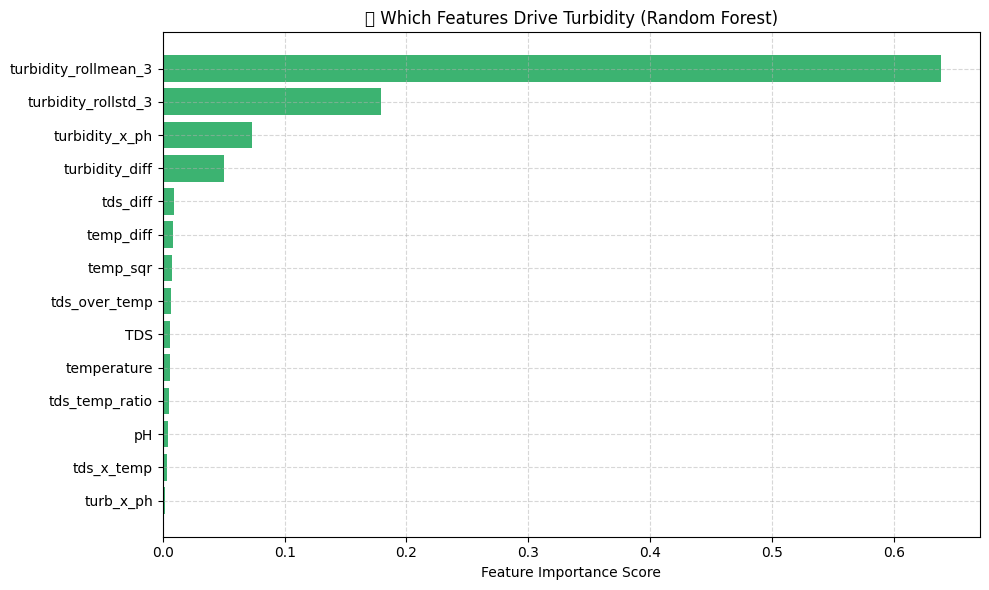

In [6]:
import matplotlib.pyplot as plt

# Get feature importances from trained model
importances = model.feature_importances_
feature_names = X.columns

# Sort them
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='mediumseagreen')
plt.xlabel("Feature Importance Score")
plt.title("🌟 Which Features Drive Turbidity ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

